In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/DDU+CE"

/content/drive/MyDrive/DDU+CE


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from metrics.AGAN import get_noise, Generator, Discriminator, calc_AGAN, calc_AGAN_dm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
plt.gray()

CE_dir = 'batch_CEs_50/'
v = 'v'                 # 'v' if validation set examples (for loading arrays)
batch_size = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_y.pt').to(device)
labels_exp = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_y.pt').unsqueeze(1).expand(batch_size, 10)
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())
originals = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_X.pt')

print('device: ', device)

device:  cuda


<Figure size 432x288 with 0 Axes>

## load CFs

In [ ]:
coeff = 4.
loss_coeff = 1
pixels = 1
m = 3

cl = '' if loss_coeff == 0 else f'cl{loss_coeff}'        # 'cl?' if combined loss, '' otherwise
p = '' if pixels == 1 else f'p{pixels}'

deduce = torch.load(CE_dir + f'arr_{v}batch_c{int(coeff)}m{m}{cl}{p}.pt').to(device)

VLK = torch.load(CE_dir + f'VLK_arr_{v}batch_c0.pt').to(device)

originals = torch.load(CE_dir + f'orig_batch_100{v}_X.pt').to(device)

### get random z

In [ ]:
torch.manual_seed(0)
z = get_noise(50,64).to(device)

# MNIST

## conventional GAN

In [ ]:
class DiscriminatorGAN(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(DiscriminatorGAN, self).__init__()
        self.disc1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(im_chan, hidden_dim, 5, 2, padding=2)),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(hidden_dim, hidden_dim * 2, 5, 2, padding=1)),
        )
        self.disc2 = nn.Sequential(
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(hidden_dim * 2, 1, 5, 2)),
        )

    def feature(self, image):
        return self.disc1(image)

    def forward(self, image):
        disc_pred = self.disc2(self.disc1(image))
        return disc_pred.view(len(disc_pred), -1)

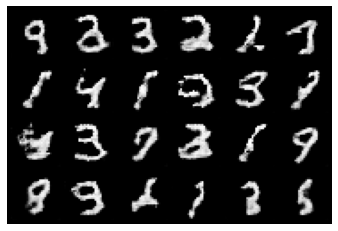

In [ ]:
num_steps = 80
name = 'GAN'

gen = Generator().to(device) 
disc = DiscriminatorGAN().to(device) 
gen.load_state_dict(torch.load(f'./metrics/{name}_gen_{num_steps}.pt', map_location=device))
disc.load_state_dict(torch.load(f'./metrics/{name}_disc_{num_steps}.pt', map_location=device))
gen.eval()
disc.eval()

image_tensor = gen(z)
image_cpu= image_tensor.detach().cpu()
image_grid = make_grid(image_cpu[:24], nrow=6)
fig = plt.figure(figsize=(9, 4))
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.show()

## Wasserstein GAN

### 1 repetition

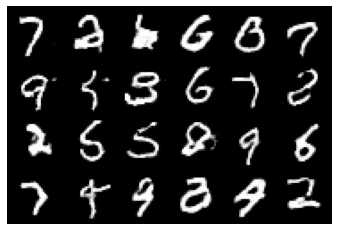

In [ ]:
num_steps = 80
name = 'WGAN11m'

gen = Generator().to(device) 
disc = Discriminator().to(device) 
gen.load_state_dict(torch.load(f'./metrics/{name}_gen_{num_steps}.pt', map_location=device))
disc.load_state_dict(torch.load(f'./metrics/{name}_disc_{num_steps}.pt', map_location=device))
gen.eval()
disc.eval()


image_tensor = gen(z)
image_cpu= image_tensor.detach().cpu()
image_grid = make_grid(image_cpu[:24], nrow=6)
fig = plt.figure(figsize=(9, 4))
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.show()

### 4 repetitions

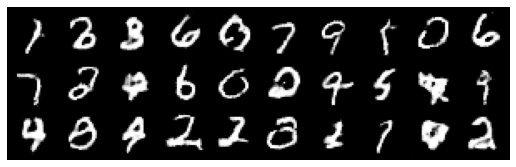

In [ ]:
num_steps = 370
name = 'WGAN41m'

gen = Generator().to(device) 
disc = Discriminator().to(device) 
gen.load_state_dict(torch.load(f'./metrics/{name}_gen_{num_steps}.pt', map_location=device))
disc.load_state_dict(torch.load(f'./metrics/{name}_disc_{num_steps}.pt', map_location=device))
gen.eval()
disc.eval()

image_tensor = gen(z)
image_cpu= image_tensor.detach().cpu()
image_grid = make_grid(image_cpu[:30], nrow=10)
fig = plt.figure(figsize=(9, 4))
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.show()

### losses

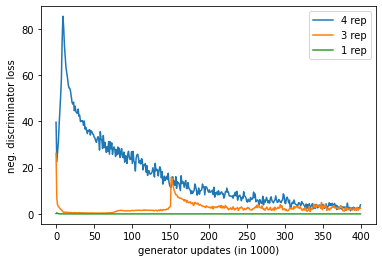

In [ ]:
name1 = 'WGAN11m'
name2 = 'WGAN31m'
name3 = 'WGAN41m'
d_loss1 = torch.load(f'./metrics/{name1}_disc_losses.pt')#[:90]
d_loss2 = torch.load(f'./metrics/{name2}_disc_losses.pt')#[:90]
d_loss3 = torch.load(f'./metrics/{name3}_disc_losses.pt')[:400]
x_axis1 = np.arange(len(d_loss3))#*1000
plt.plot(x_axis1, - d_loss3, label='4 rep')
#plt.plot(x_axis1, - d_loss2, label='3 rep')
plt.plot(x_axis1, - d_loss1, label='1 rep')
plt.xlabel('generator updates (in 1000)')
plt.ylabel('neg. discriminator loss')
#plt.xticks(ticks=[100000,200000,300000])
plt.legend()

In [ ]:
print(-d_loss2[110].item(), -d_loss3[40].item())

1.1212974786758423 36.04648208618164


# AnoGAN metric tuning

In [ ]:
def anoGANim(image, steps=4000, lam=.1, step_size=0.015, random=False):
    if random:
        z = get_noise(1, 64, device=device)
    else:
        z = torch.zeros((1,64), device=device)
    im_feature = disc.feature(image.view(1,1,28,28))
    for i in range(steps):
        z.requires_grad = True
        z.grad = None
        disc.zero_grad()
        gen.zero_grad()
        assert z.grad is None
        new_image = gen(z)
        res_loss = torch.abs(image - new_image).sum()
        disc_loss = torch.abs(im_feature - disc.feature(new_image)).sum()
        loss = res_loss + disc_loss * lam
        loss.backward(retain_graph=True)
        z.requires_grad = False
        #z_grad = z.grad.clone()
        z -= z.grad * step_size

        if i == steps - (steps // 5):
            step_size /= 10
        
        if i % 100 == 0:
            #plt.imshow(new_image.detach().view(28,28))
            #plt.axis('off')
            #plt.show()
            print(res_loss.item(), disc_loss.item())

    plt.imshow(new_image.detach().view(28,28).cpu())
    plt.axis('off')
    plt.show()
    print(res_loss.item(), disc_loss.item())
    print(loss.item())

    return new_image.detach().view(28,28).cpu()

In [ ]:
idx = 19
target = 2

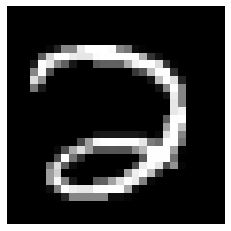

184.162841796875 100.68955993652344
92.73007202148438 65.8537826538086
57.440860748291016 35.51605224609375
48.99445724487305 29.8453369140625
66.62144470214844 41.50239562988281
50.258846282958984 30.883625030517578
65.027587890625 34.11140060424805
43.53346252441406 23.320884704589844
54.53828048706055 28.994239807128906
47.65397644042969 23.587318420410156
38.58760070800781 19.845584869384766
41.78924560546875 22.582046508789062
42.328399658203125 21.729385375976562
36.30754852294922 18.122041702270508
40.16969680786133 18.81612777709961
39.629364013671875 19.85123634338379
47.16168975830078 24.170909881591797
35.48735046386719 16.532306671142578
38.97953796386719 18.25948715209961
38.27478790283203 17.567852020263672
34.452579498291016 17.605777740478516
49.13533020019531 29.393150329589844
37.161590576171875 16.51491355895996
34.336002349853516 16.796640396118164
35.23802185058594 16.68659210205078
31.68722915649414 16.30754852294922
33.5362663269043 16.88880157470703
34.917526245

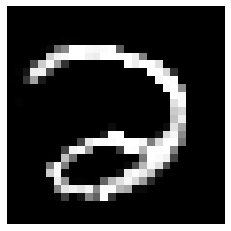

26.580429077148438 13.650638580322266
27.945493698120117


In [ ]:
im00 = deduce[idx][target].view(28,28) #0,6

plt.imshow(im00.cpu())
plt.axis('off')
plt.show()

im01 = anoGANim(im00, steps=4000, lam = .1, step_size=0.15, random=False) # 36,13

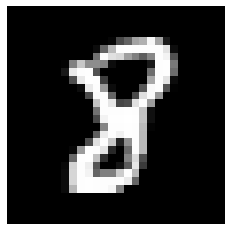

97.4709243774414 47.24824523925781
30.088037490844727 12.616525650024414
29.06977081298828 12.920358657836914
22.395660400390625 10.245553970336914
26.981382369995117 11.286962509155273
20.92922592163086 9.373215675354004
21.11979866027832 9.583686828613281
19.783571243286133 8.932572364807129
21.184768676757812 8.775947570800781
20.96907615661621 8.985766410827637
19.81855010986328 8.384902954101562
20.56193733215332 8.876604080200195
21.520017623901367 9.031633377075195
20.5196533203125 8.885804176330566
19.034469604492188 8.323310852050781
20.390066146850586 8.593263626098633
19.912227630615234 8.287013053894043
19.245643615722656 7.896374702453613
19.499713897705078 8.184335708618164
19.994552612304688 9.149640083312988
18.869407653808594 8.160062789916992
19.961833953857422 8.107674598693848
18.513036727905273 8.020319938659668
18.328601837158203 8.022040367126465
17.997224807739258 7.9381632804870605
19.27484893798828 8.272692680358887
18.886821746826172 8.233896255493164
18.5433

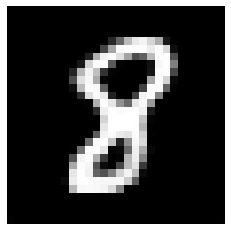

17.109424591064453 7.78800106048584
17.888225555419922


In [ ]:
label = 8
im10 = deduce[idx][label].view(28,28)

plt.imshow(im10.cpu())
plt.axis('off')
plt.show()

im11 = anoGANim(im10, steps=4000, lam = .1, step_size=0.015)

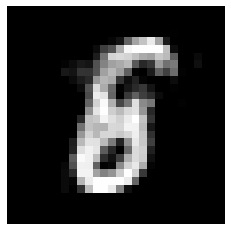

76.87438201904297 41.289886474609375
35.93879699707031 12.453495025634766
29.88477325439453 11.095813751220703
27.50652313232422 10.81321907043457
27.641952514648438 10.596712112426758
30.551511764526367 11.323171615600586
29.612411499023438 11.052617073059082
28.151134490966797 11.56113052368164
28.4659366607666 11.392206192016602
33.181419372558594 12.571599960327148
29.21151351928711 11.99385929107666
31.73787498474121 12.291727066040039
26.710359573364258 10.87205982208252
25.50448226928711 9.640020370483398
26.200485229492188 10.592826843261719
26.401248931884766 10.146526336669922
27.88330078125 10.839658737182617
25.194183349609375 9.147894859313965
25.34207534790039 9.401225090026855
29.313894271850586 9.929742813110352
23.0195255279541 8.23855972290039
23.883689880371094 8.92034912109375
23.134889602661133 8.593728065490723
22.82889175415039 8.385984420776367
21.390888214111328 7.823370933532715
23.351451873779297 8.411805152893066
21.34107208251953 7.925217628479004
25.294412

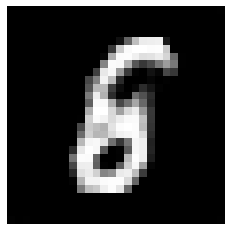

18.84531593322754 7.300123691558838
19.575328826904297


In [ ]:
im20 = VLK[idx][target].view(28,28)

plt.imshow(im20.cpu())
plt.axis('off')
plt.show()

im21 = anoGANim(im20, steps=4000, lam = .1, step_size=0.015, random=False)# 37,14

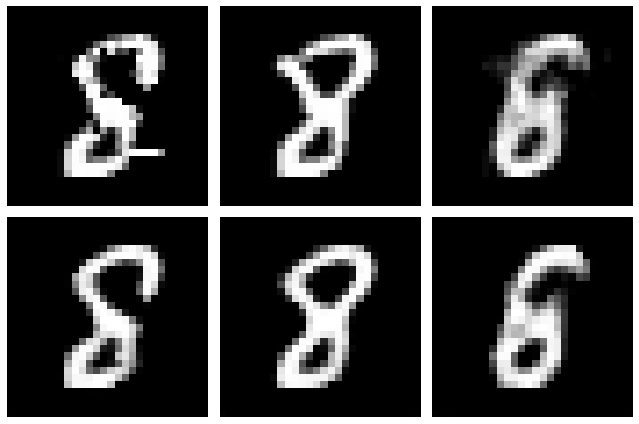

In [ ]:
fig = plt.figure(figsize=(9,6))

# top row
ax = plt.subplot2grid((2,3), (0, 0))
plt.imshow(im00.cpu())
plt.axis('off')
ax = plt.subplot2grid((2,3), (0, 1))
plt.imshow(im10.cpu())
plt.axis('off')
ax = plt.subplot2grid((2,3), (0, 2))
plt.imshow(im20.cpu())
plt.axis('off')

# top row
ax = plt.subplot2grid((2,3), (1, 0))
plt.imshow(im01.cpu())
plt.axis('off')
ax = plt.subplot2grid((2,3), (1, 1))
plt.imshow(im11.cpu())
plt.axis('off')
ax = plt.subplot2grid((2,3), (1, 2))
plt.imshow(im21.cpu())
plt.axis('off')

plt.tight_layout()

[30.86, 13.24, 12.07, 12.28, 12.55, 15.81, 8.28, 8.98, 16.48, 25.37]
[51.82 21.24 14.28 13.62 80.37 27.18 16.17 22.32 14.71 20.93]
[ 27.88  19.77  12.87 361.25  66.11  22.65  63.98  28.05 281.1   47.75]


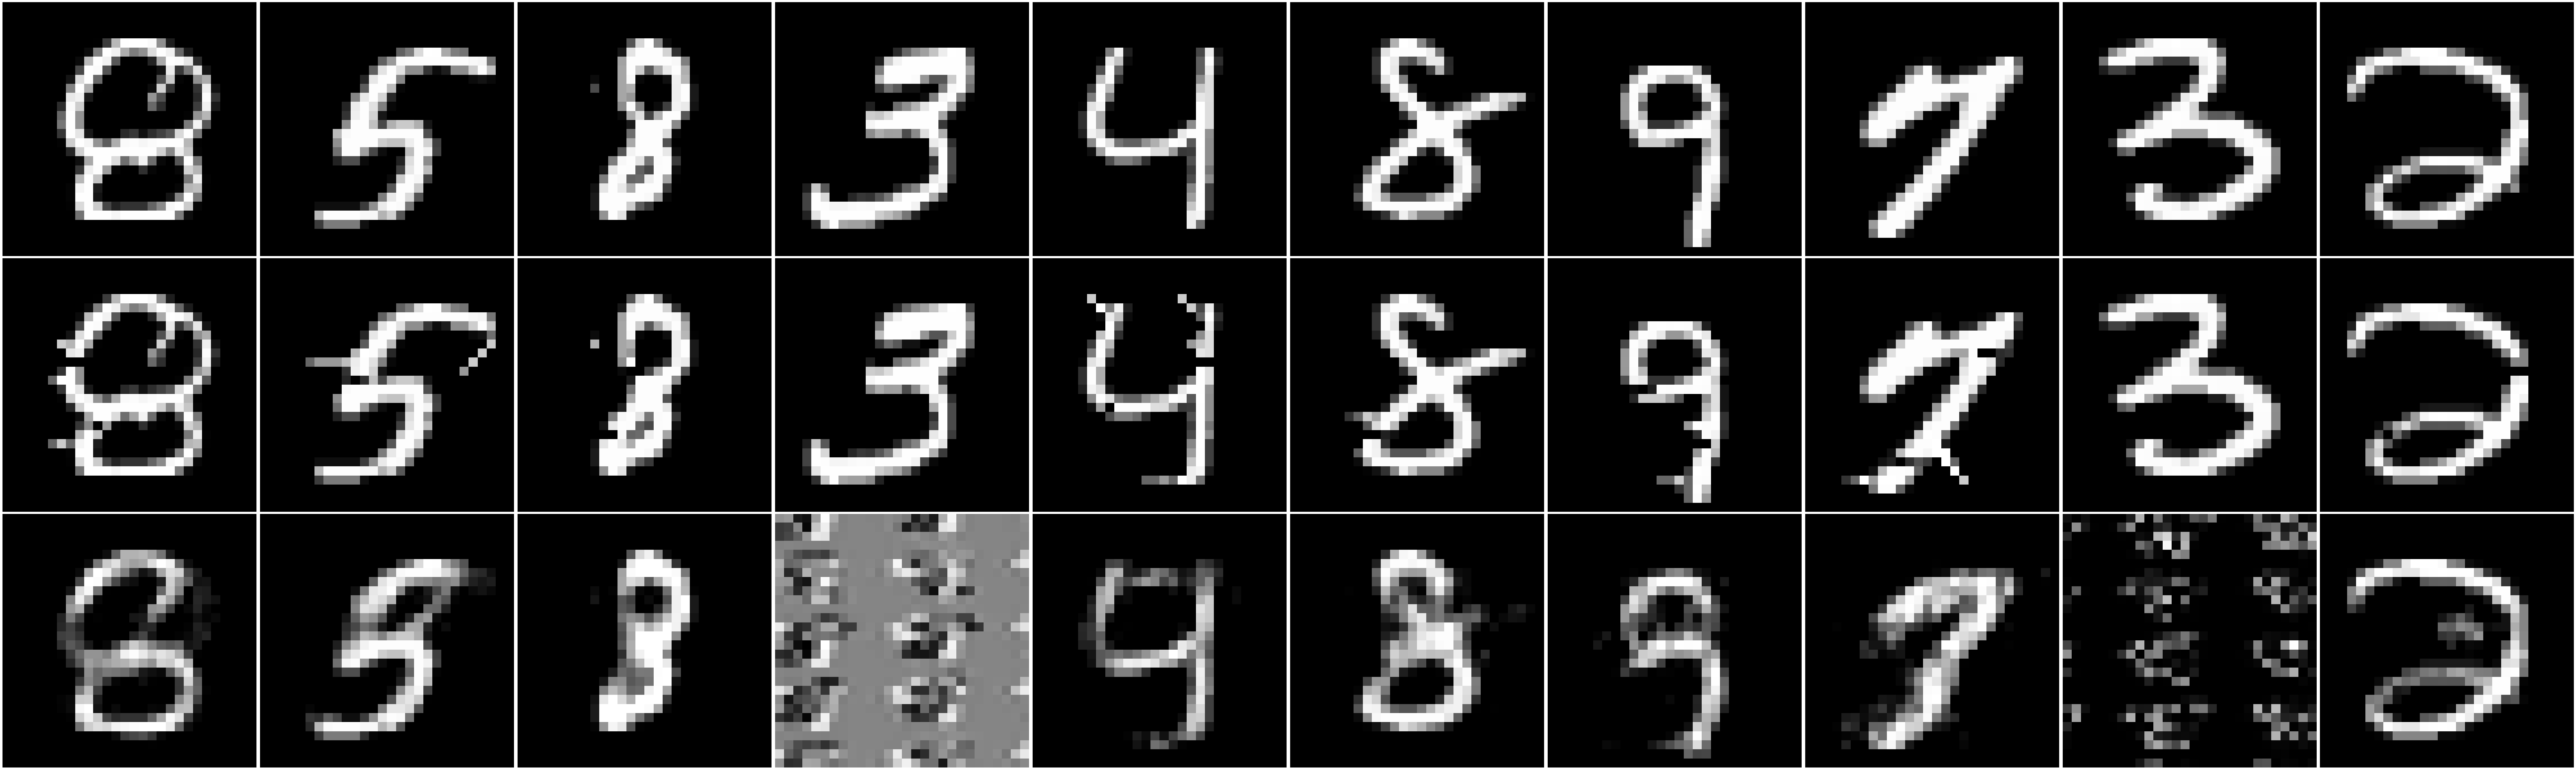

In [ ]:
n_rows = 3

def r2(x):
    return np.round(x, 2)


fig = plt.figure(figsize=(100, n_rows*10))
num=10

start = 10
target = 3

orig_AGAN = []
for i in range(num):
    ax = plt.subplot2grid((n_rows,num), (0, i))
    plt.imshow(originals[start+i].view(28,28))
    plt.axis('off')
    orig_AGAN.append(np.round(calc_AGAN(deduce[start+i,labels[start+i]].view(1,1,28,28).to(device), 4000)[0], 2))
print(orig_AGAN)

for i in range(num):
    ax = plt.subplot2grid((n_rows,num), (1, i))
    plt.imshow(deduce[start+i,target].cpu().view(28,28))
    plt.axis('off')
print(r2(calc_AGAN(deduce[start:start+num, target].view(num,1,28,28), 4000)))

for i in range(num):
    ax = plt.subplot2grid((n_rows,num), (2, i))
    plt.imshow(VLK[start+i,target].cpu().view(28,28))
    plt.axis('off')
print(r2(calc_AGAN(VLK[start:start+num, target].view(num,1,28,28), 3000)))

plt.tight_layout()

# testset MNIST

In [ ]:
CE_dir = '_testset_results5/'

deduce_t = torch.load(CE_dir + f'DeDUCE_arr_c4m6cl1p1.pt').to(device)

VLK_t = torch.load(CE_dir + f'VLK_arr_c0.pt').to(device)

In [ ]:
print('calculating scores...')

GANs = np.empty((100, 10))#.to(device)
GANsVLK = np.empty((100, 10))#.to(device)

for target_class in range(10):
    # get counterfactual
    x = deduce_t[:,target_class].reshape(100,1,28,28)
    vlk = VLK_t[:,target_class].reshape(100,1,28,28)
    
    # calculate and put into tensor
    GANs[:,target_class] = calc_AGAN(x)
    GANsVLK[:,target_class] = calc_AGAN(vlk)
    
    print(target_class)
        
np.save(CE_dir + f'DeDUCE_AGAN_c4m6cl1p1.npy', GANs)
np.save(CE_dir + f'VLK_AGAN_c0.npy', GANsVLK)

print('average original: ', GANs[targets == labels_exp].mean()) # 25.0; 
print('average DeDUCE: ', GANs[targets != labels_exp].mean()) # 26.0; 
print('average VLK: ', GANsVLK[targets != labels_exp].mean()) # 24.2; 

calculating scores...
0
1
2
3
4
5
6
7
8
9
average original:  23.132820420265197
average DeDUCE:  22.32973139497969
average VLK:  36.63580660502116


In [ ]:
JSMA_t = torch.load(CE_dir + f'JSMA_arr_c0p1.pt').to(device)

REVISE_t = torch.load(CE_dir + f'REVISE_l0s-5_arr_c0.pt').to(device)

In [ ]:
print('calculating scores...')

GANs1 = np.empty((100, 10))#.to(device)
GANs2 = np.empty((100, 10))#.to(device)

for target_class in range(10):
    # get counterfactual
    x1 = JSMA_t[:,target_class].reshape(100,1,28,28)
    x2 = REVISE_t[:,target_class].reshape(100,1,28,28)
    
    # calculate and put into tensor
    GANs1[:,target_class] = calc_AGAN(x1)
    GANs2[:,target_class] = calc_AGAN(x2)
    
    print(target_class)
        
np.save(CE_dir + f'JSMA_AGAN_c0p1.npy', GANs1)
np.save(CE_dir + f'REVISE_l0s-5_AGAN_c0.npy', GANs2)

print('average JSMA: ', GANs1[targets != labels_exp].mean()) # 27.8
print('average REVISE: ', GANs2[targets != labels_exp].mean()) # 18.8
print('average original REVISEd: ', GANs2[targets == labels_exp].mean()) # 20.9

calculating scores...
0
1
2
3
4
5
6
7
8
9
average JSMA:  23.28228452190702
average REVISE:  14.673836378324372
average original REVISEd:  14.814683272254188
